In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import json
import glob
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import PrecisionRecallDisplay, mean_squared_error, precision_recall_fscore_support, precision_recall_curve
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
from nltk import PorterStemmer

from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy as sup_accuracy
from surprise import SVDpp
from surprise.model_selection import GridSearchCV



import warnings
# Ignore future deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')


In [2]:
#reviews = pd.read_csv(r"..\Data\.reviews_data.csv")
#reviews

In [3]:
# Rename the column at a specific index
#reviews.rename(columns={reviews.columns[0]: 'userId'}, inplace=True)


In [4]:
#reviews = reviews[['userId', 'placeid', 'rating', 'text', 'placeInfo' ]]
#reviews

In [5]:
# Split the dictionary-like item into separate columns
#item_info = reviews['placeInfo'].apply(lambda x: pd.Series(eval(x)))
#item_info.drop(columns='id', inplace=True)

# Concatenate the new columns with the original DataFrame
#reviews = pd.concat([reviews, item_info], axis=1)
#reviews.head()

In [6]:

# Split the dictionary-like item into separate columns
#address_info = reviews['addressObj'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
#reviews = pd.concat([reviews, address_info], axis=1)
#reviews.head()


In [7]:
# Calculate the percentage of NaN values in each column
#nan_percentage = reviews.isnull().sum() / len(reviews) * 100

# Define a threshold for excluding columns with a high percentage of NaN values
#nan_threshold = 50  # Adjust this value as needed

# Exclude columns with a high percentage of NaN values
#cleaned_dataset = reviews.dropna(thresh=len(reviews) - nan_threshold, axis=1)


In [8]:
# Remove rows with NaN variables
#reviews = reviews.dropna()
#reviews.drop(columns=['placeInfo', 'addressObj'], inplace=True)

# Set the desired sample size
#sample_size = 5000

# Perform random sampling
#random_sample = reviews.sample(n=sample_size, random_state=42)

In [9]:
model_data = pd.read_csv(r"..\Data\reviews.csv")
model_data.head()

,id,userId,placeid,rating,lang,text
0,863480416,A87669AAD9DA05FFBD46F1334B329FFD,2189822,5,en,Gee is a passionate tour guide. The animals a...
1,856328161,9FFED7DDC68883BBB8F4024333970E9A,2189822,5,en,Lots to see. Easy to get to from the Safari Lo...
2,847451595,B5E56A483B579518DDD82A3DA0E94487,2189822,4,en,a kind of a zoo for injured and saved animals ...
3,731343195,882D0A6C7152105BB0D83C84F3CB160D,2189822,5,en,They do great rehabilitating injured animals. ...
4,720927932,203EBC7F3F51AAAA39A87D2E58842C76,2189822,5,en,"We took the guided tour from Isaac, who was gr..."


Columns to plot: Index(['id', 'placeid', 'rating'], dtype='object')


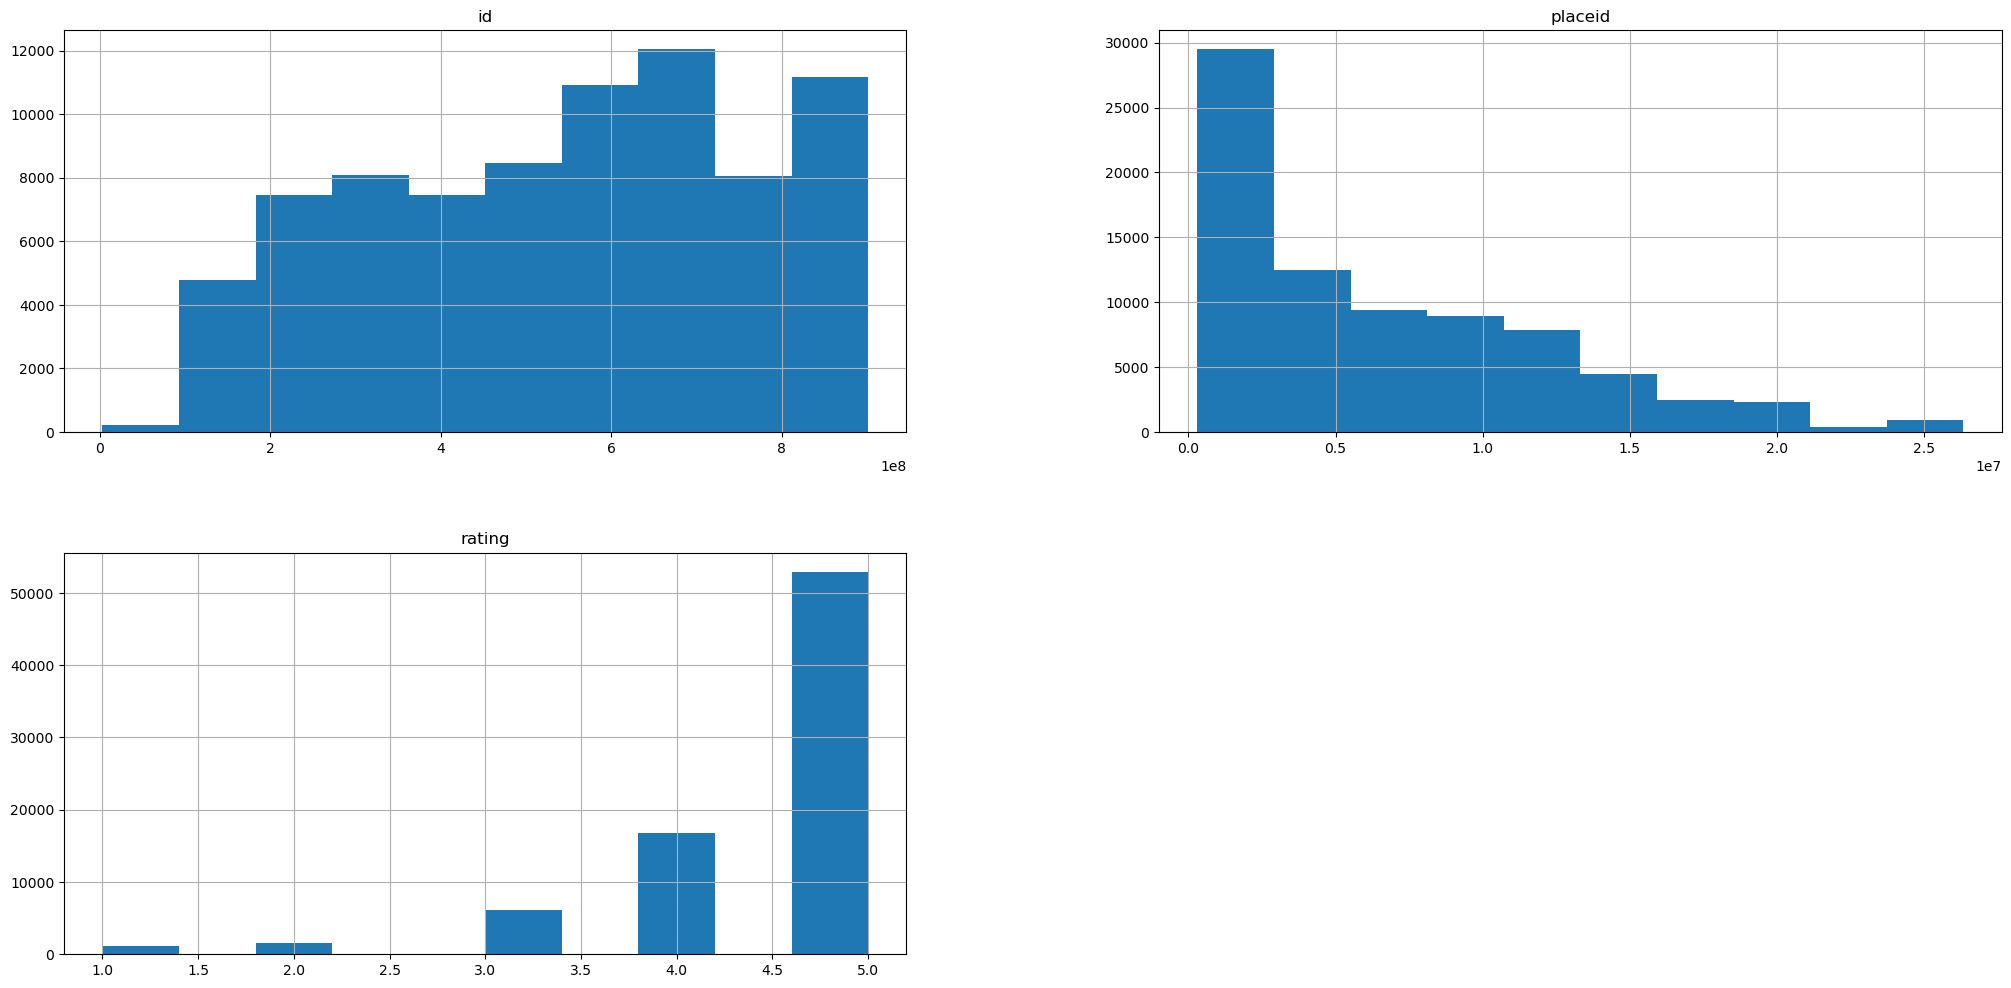

In [10]:
# Histogram plots for each data
# Select the numerical variables to plot
num_cols_to_plot = model_data.select_dtypes(include=['int64', 'float64']).columns.drop([])
print("Columns to plot:",num_cols_to_plot )
# Create a histogram for each variable
model_data[num_cols_to_plot].hist(figsize=(25, 12))
#plt.savefig('../Data/images/Columnstoplot')
plt.show()

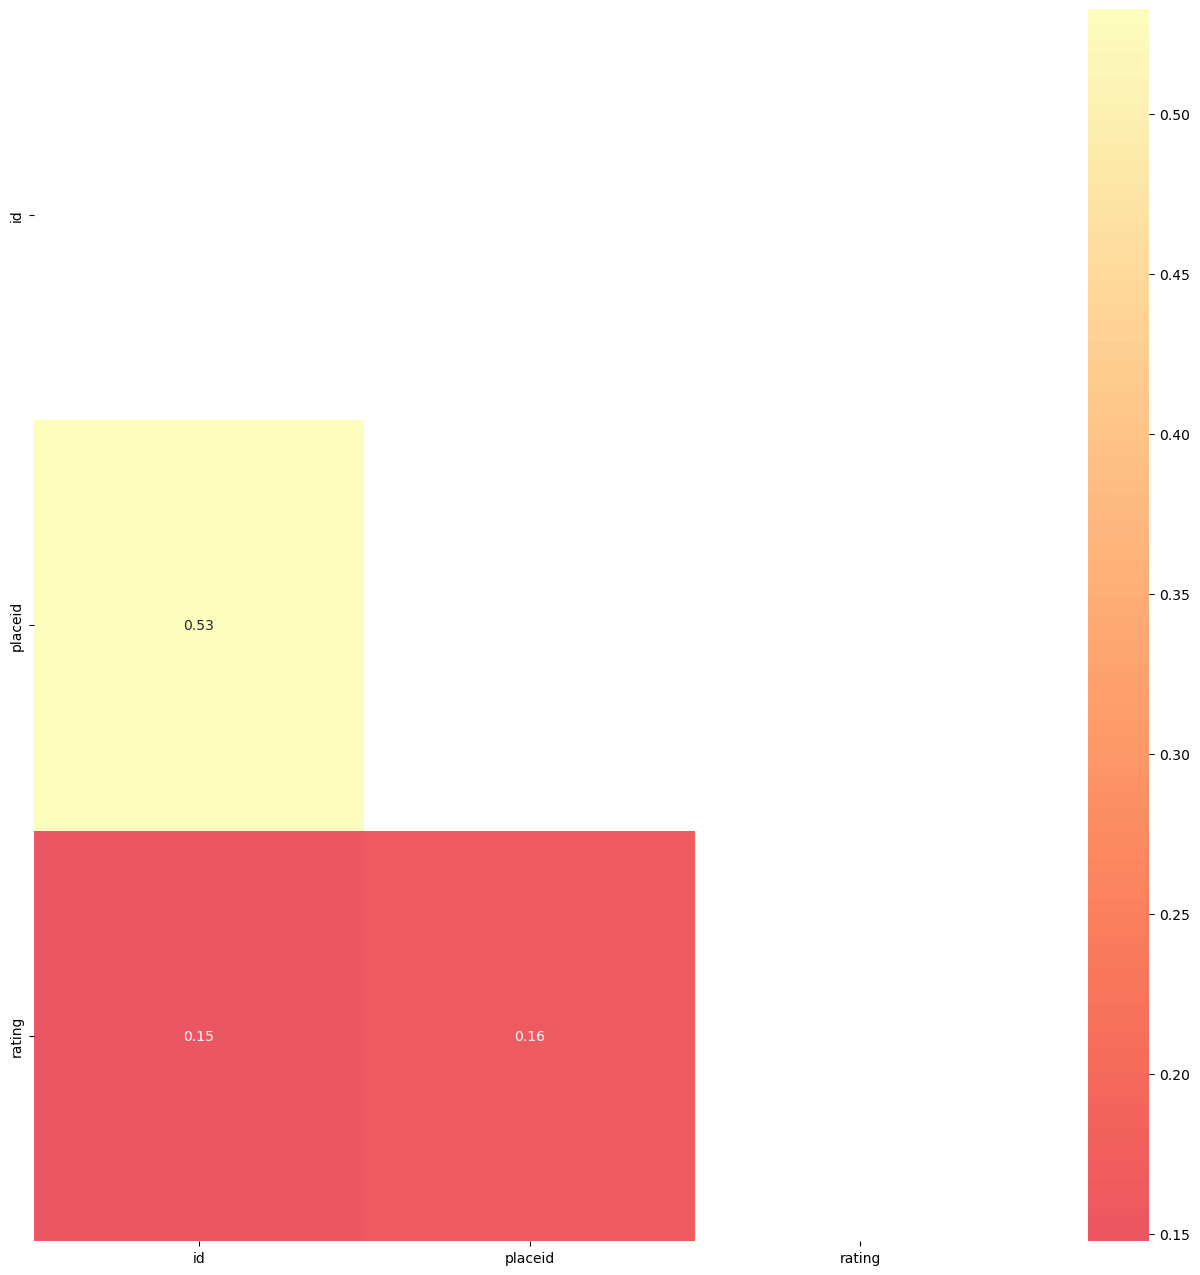

In [11]:
## Multicollinearity

# Create a correlation matrix
corr_matrix = model_data.corr()
# Create a fig size
plt.figure(figsize=(16, 16))
# Create a mask to show only the lower triangle
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with the lower triangle mask applied
sns.heatmap(corr_matrix, mask=mask, cmap='magma', center=0, annot=True)
# Show the plot
plt.show();
# Save figure
#plt.savefig('../Data/images/multicollinearity.png')

In [12]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(model_data[['id', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model = SVD(random_state=42)
model.fit(trainset)

# Evaluate the model
predictions = model.test(testset)
accuracy = sup_accuracy.rmse(predictions)


RMSE: 0.7513


The RMSE (Root Mean Squared Error) value of 0.7513 indicates the average prediction error of the model on the test set. A lower RMSE value indicates better accuracy of the model's predictions.

In the context of collaborative filtering recommendation systems, the RMSE represents how well the model is able to predict user ratings for items. A lower RMSE implies that the model is better at predicting user preferences and provides more accurate recommendations.

RMSE of 0.7513 suggests that the model has reasonably good predictive performance. as can be observed below.

In [13]:
threshold = 3  # Define the threshold for positive predictions

true_positives = 0
false_positives = 0
false_negatives = 0

for prediction in predictions:
    if prediction.est >= threshold:
        if prediction.r_ui >= threshold:
            true_positives += 1
        else:
            false_positives += 1
    elif prediction.r_ui >= threshold:
        false_negatives += 1

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.97
Recall: 1.00


In [14]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(model_data[['id', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model2 = NMF(random_state=42)
model2.fit(trainset)

# Evaluate the model
predictions2 = model2.test(testset)
accuracy2 = sup_accuracy.rmse(predictions2)
mae2 = sup_accuracy.mae(predictions2)

threshold = 1  # Define the threshold for positive predictions

true_positives = 0
false_positives = 0
false_negatives = 0

for prediction in predictions2:
    if prediction.est >= threshold:
        if prediction.r_ui >= threshold:
            true_positives += 1
        else:
            false_positives += 1
    elif prediction.r_ui >= threshold:
        false_negatives += 1

precision2 = true_positives / (true_positives + false_positives)
recall2 = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision2:.2f}")
print(f"Recall: {recall2:.2f}")

RMSE: 0.8497
MAE:  0.6643
Precision: 1.00
Recall: 1.00


In [15]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(model_data[['id', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define the item-based collaborative filtering model
model3 = SVDpp(random_state=42)

# Train the model
model3.fit(trainset)

# Make predictions on the test set
predictions3 = model3.test(testset)

# Evaluate the model using RMSE
rmse_score3 = sup_accuracy.rmse(predictions3)
mae3 = sup_accuracy.mae(predictions3)

# Extract the actual ratings and predicted ratings from the predictions
actual_ratings3 = [pred.r_ui for pred in predictions3]
predicted_ratings3 = [pred.est for pred in predictions3]

# Calculate the R-squared value
r_squared3 = r2_score(actual_ratings3, predicted_ratings3)
print("R-squared:", r_squared3) 

RMSE: 0.7616
MAE:  0.5253
R-squared: 0.19655916134101215


In [16]:
model_data.columns

Index(['id', 'userId', 'placeid', 'rating', 'lang', 'text'], dtype='object')

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaled_data = model_data[[ 'id', 'placeid', 'rating']]
# Apply MinMaxScaler to 'rating' and 'Rank' columns
scaler = MinMaxScaler()
scaled_data[['id', 'placeid', 'rating']] = scaler.fit_transform(scaled_data[[ 'id', 'placeid', 'rating']])

scaled_data[[ 'id', 'placeid', 'rating']]

C:\Users\BobbyBob\AppData\Local\Temp\ipykernel_9876\3832156891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data[['id', 'placeid', 'rating']] = scaler.fit_transform(scaled_data[[ 'id', 'placeid', 'rating']])


,id,placeid,rating
0,0.958014,0.072206,1.00
1,0.950050,0.072206,1.00
2,0.940166,0.072206,0.75
3,0.810881,0.072206,1.00
4,0.799284,0.072206,1.00
...,...,...,...
78671,0.172030,0.092596,1.00
78672,0.147625,0.092596,1.00
78673,0.140697,0.092596,0.75
78674,0.365516,0.092596,0.75


In [18]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(scaled_data[['id', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model4 = SVD(random_state=42)
model4.fit(trainset)

# Evaluate the model
predictions4 = model4.test(testset)
accuracy4 = sup_accuracy.rmse(predictions4)
mae4 = sup_accuracy.mae(predictions4)



RMSE: 0.2461
MAE:  0.1242


Root Mean Squared Error (RMSE): The RMSE value of 0.2461 indicates the average difference between the predicted ratings and the actual ratings in the test set. A lower RMSE value indicates better accuracy.

Mean Absolute Error (MAE): The MAE value of 0.1242 represents the average absolute difference between the predicted ratings and the actual ratings. Similar to RMSE, a lower MAE value indicates better accuracy.

These metrics suggest that the model performs reasonably well in predicting the ratings, as both the RMSE and MAE values are relatively low.

In [19]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(scaled_data[['id', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model5 = NMF(random_state=42)
model5.fit(trainset)

# Evaluate the model
predictions5 = model5.test(testset)
accuracy5 = sup_accuracy.rmse(predictions5)
mae5 = sup_accuracy.mae(predictions5)

RMSE: 0.2461
MAE:  0.1242


In [23]:
from collections import defaultdict

def calculate_precision_recall(predictions, threshold):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for prediction in predictions:
        if prediction.r_ui < threshold:
            false_positives += 1
        elif prediction.r_ui >= threshold:
            true_positives += 1
        else:
            false_negatives += 1

    precision = 0.0
    recall = 0.0

    if (true_positives + false_positives) != 0:
        precision = true_positives / (true_positives + false_positives)

    if (true_positives + false_negatives) != 0:
        recall = true_positives / (true_positives + false_negatives)

    return precision, recall


#def calculate_topn_hit_rate(predictions, topn):
    #total_users = len({pred.uid for pred in predictions})
    #topn_hits = 0

    #user_ratings = defaultdict(list)
    #for pred in predictions:
       # user_ratings[pred.uid].append((pred.iid, pred.est))

    #for uid, ratings in user_ratings.items():
       # ratings.sort(key=lambda x: x[1], reverse=True)
        #topn_predictions = [iid for (iid, _) in ratings[:topn]]
       # if uid in topn_predictions:
        #    topn_hits += 1

    #return topn_hits / total_users

def evaluate_prediction_sets(prediction_sets, threshold):
    for predictions, name in prediction_sets:
        precision, recall = calculate_precision_recall(predictions, threshold)
        #hit_rate = calculate_topn_hit_rate(predictions, topn)
        
        print("Results for", name)
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        #print(f"Top-{topn} Hit Rate: {hit_rate:.2f}")
        print()


In [24]:
# Usage example
prediction_sets = [
    (predictions, "Predictions 1"),
    (predictions2, "Predictions 2"),
    (predictions3, "Predictions 3"),
    (predictions4, "Predictions 4"),
    (predictions5, "Predictions 5"),
    #(predictions6, "Predictions 6"),
    #(predictions7, "Predictions 7"),
    #(predictions6, "Predictions 8"),
    #(predictions6, "Predictions 9"),
    #(predictions6, "Predictions 10"),
    #(predictions6, "Predictions 11"),
]

threshold = 1
#topn = 2

evaluate_prediction_sets(prediction_sets, threshold)

Results for Predictions 1
Precision: 1.00
Recall: 1.00

Results for Predictions 2
Precision: 1.00
Recall: 1.00

Results for Predictions 3
Precision: 1.00
Recall: 1.00

Results for Predictions 4
Precision: 0.67
Recall: 1.00

Results for Predictions 5
Precision: 0.67
Recall: 1.00



The precision and recall values for Predictions 1, 2, and 3 are all 1.00, indicating perfect precision and recall for those sets.

In the case of Predictions 4, the precision is 0.67 and the recall is 1.00. This means that the model achieved a precision of 0.67, indicating that 67% of the instances classified as positive were actually true positives. The recall value of 1.00 suggests that the model successfully identified all positive instances.

In [27]:
# Initialize CountVectorizer object with a maximum of 5000 features and English stop words.
cv = CountVectorizer(max_features = 5000, stop_words="english")

# Apply CountVectorizer to the 'tags' column of the new_movies DataFrame.
cv.fit_transform(model_data["text"]).toarray()

# Apply CountVectorizer again to the 'tags' column to transform the text data into an array.
vectors = cv.fit_transform(model_data["text"]).toarray()

In [28]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [30]:
# Calculate similarity matrix
similarity = cosine_similarity(vectors)

MemoryError: Unable to allocate 46.1 GiB for an array with shape (78676, 78676) and data type float64

In [ ]:
sorted(list(enumerate(similarity[2])), reverse= True, key=lambda x:x[1])[1:7]

In [ ]:
def recommend(place):
    place_index = model_data[model_data["name"]==name].index[0]
    distances = similarity[place_index_index]
    place_list = sorted(list(enumerate(distances)), reverse = True, key = lambda x:x[1])[1:7]

    for i in place_list:
        print(model_data.iloc[i[0]].name)

In [ ]:
# Testing the function
recommend("Avatar")

In [ ]:
# Construct the TF-IDF Matrix
tfidfv=TfidfVectorizer(analyzer='word', stop_words='english')
tfidfv_matrix1=tfidfv.fit_transform(model_data['text'])
print(tfidfv_matrix1.todense())
tfidfv_matrix1.todense().shape


# Calculate similarity matrix
cosine_sim1 = cosine_similarity(tfidfv_matrix1, tfidfv_matrix1)


# Create a Pandas Series to map movie titles to their indices
indices = pd.Series(data = list(model_data.index), index = model-data['name'])


In [ ]:
def recommend_place(name, cosine_sim1, model_data):
    # Create a dictionary to map movie titles to their indices
    indices = {title: index for index, title in enumerate(model_data['name'])}

    # Get the index of the movie that matches the title
    idx = indices[name]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim1[idx]))

    # Sort the movies based on the similarity scores
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    indices = [x for x, _ in sim_scores]

    # Return the top 10 most similar movies
    recommended_movies = movies_data.iloc[indices]['name']
    return recommended_place


In [ ]:
# Function that takes in movie title as input and outputs most similar places
def hybrid_recommendations(userId, name):
    
    # Get the index of the place that matches the name
    idx = indices[name]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_similarities[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar places
    sim_scores=sim_scores[1:11]
    
    # Get the place indices
    ind=[]
    for (x,y) in sim_scores:
        ind.append(x)
        
    
        
    # Predict the ratings a user might give to these top 10 most similar movies
    est_rating=[]
    for a in placeid:
        est_rating.append(svd.predict(id, a, r_ui=None).est)  
        
    return pd.DataFrame({'index': ind, 'name':tit, 'placeid':placeid, 'estimated_rating':est_rating}).set_index('index').sort_values(by='estimated_rating', ascending=False)


In [ ]:
# Applying the function
hybrid_recommendations(7,'placename')